## Impact of filter scales and deformation radii 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2024-10-10 15:52:24.962653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 15:52:24.962679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 15:52:24.963995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
experiment_config= {'experiment_name': 'deformation_radius', # Any sort of name will work here 
                    'simulation_names':['DG','P2L'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':1, 
                    
                    'input_channels' : ['dudx_widened_nondim',  
                                        'dvdx_widened_nondim', 
                                        'dudy_widened_nondim',
                                        'dvdy_widened_nondim',
                                        'dhdx_widened',
                                        'dhdy_widened'],
                    
                    'output_channels' : ['uphp_nondim',
                                         'vphp_nondim'],
                    
                    'coeff_channels'  : [], 
                    
                    'extra_channels': ['filter_scale',
                                       'mag_nabla_u_widened',
                                       'uphp',
                                       'vphp'],

                    'all_time_range': slice(0, 1400), 
                    'train_time_range': slice(0, 1200),
                    'test_time_range' : slice(-100, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 
                   
                    'network_shape': [36, 36, 2],
                    'single_layer_mask': True}

experiment_config['all_ml_variables'] = (experiment_config['input_channels'] + 
                                           experiment_config['output_channels'] +
                                           experiment_config['coeff_channels']+ 
                                           experiment_config['extra_channels'])

experiment_config['num_inputs'] = (len(experiment_config['input_channels']))*experiment_config['window_size']**2 
experiment_config['exp_ckpt_save_dir'] = ('/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/non_dim_models/' + 
                                          '_'.join(experiment_config['simulation_names']) + 
                                          '_' + str(experiment_config['window_size']) )

In [6]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'],
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask=experiment_config['single_layer_mask'])

In [67]:
ds_DG = DT.simulation_data['DG']['50']
ds_P2L = DT.simulation_data['P2L']['50']

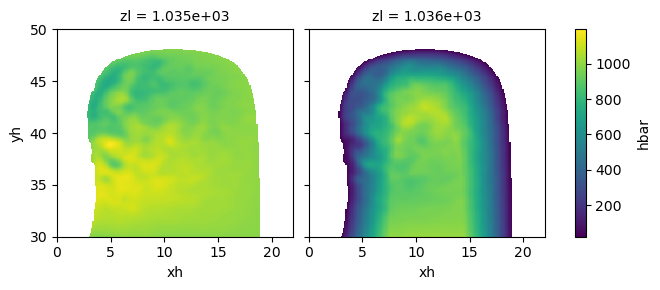

In [68]:
ds_DG.hbar.isel(Time=-1).plot(col='zl')

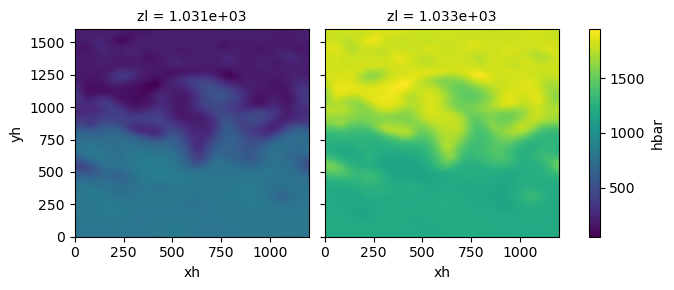

In [69]:
ds_P2L.hbar.isel(Time=-1).plot(col='zl')

In [70]:
ds_DG['delta'] = ds_DG.hbar.isel(zl=0)/ds_DG.hbar.isel(zl=1)
ds_P2L['delta'] = ds_P2L.hbar.isel(zl=0)/ds_P2L.hbar.isel(zl=1)

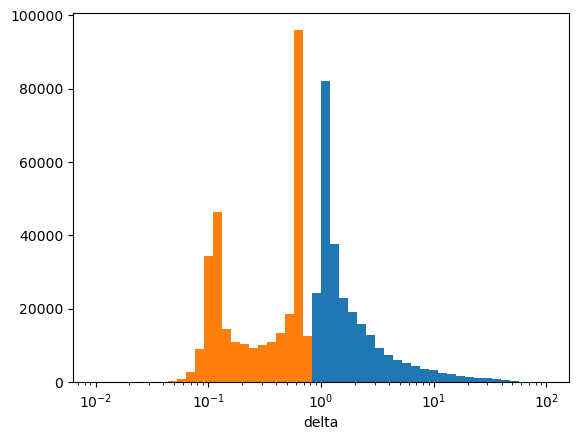

In [71]:
bins = np.logspace(-2,2,51)

ds_DG.delta.isel(Time=slice(-10,None)).plot.hist(bins=bins);
ds_P2L.delta.isel(Time=slice(-10,None)).plot.hist(bins=bins);
plt.xscale('log')
#plt.yscale('log')


In [72]:
def add_Rd(ds, exp = 'P2L'): 


    if exp == 'DG':
        #ds = ds_DG
        f = 2 * 2*np.pi/(24*3600) * np.sin(ds.yh * np.pi/180)
    elif exp =='P2L':
        #ds = ds_P2L
        F_0 = 6.49E-05
        BETA = 2.0E-11
        f = F_0 + BETA * ds.yh
    
    
    g = 9.8
    gp = ((ds.zl[1] - ds.zl[0])/ds.zl[0] * g).values
    
    cg = np.sqrt(gp * ds.hbar.isel(zl=0) * ds.hbar.isel(zl=1) / (ds.hbar.isel(zl=0) + ds.hbar.isel(zl=1)))
    
    
    
    Rd = cg/f # forumula 4 in Hallberg et al 2013

    ds['Rd'] = Rd
    
    return ds

In [73]:
ds_DG = add_Rd(ds_DG, exp='DG')

In [74]:
ds_P2L = add_Rd(ds_P2L, exp='P2L')

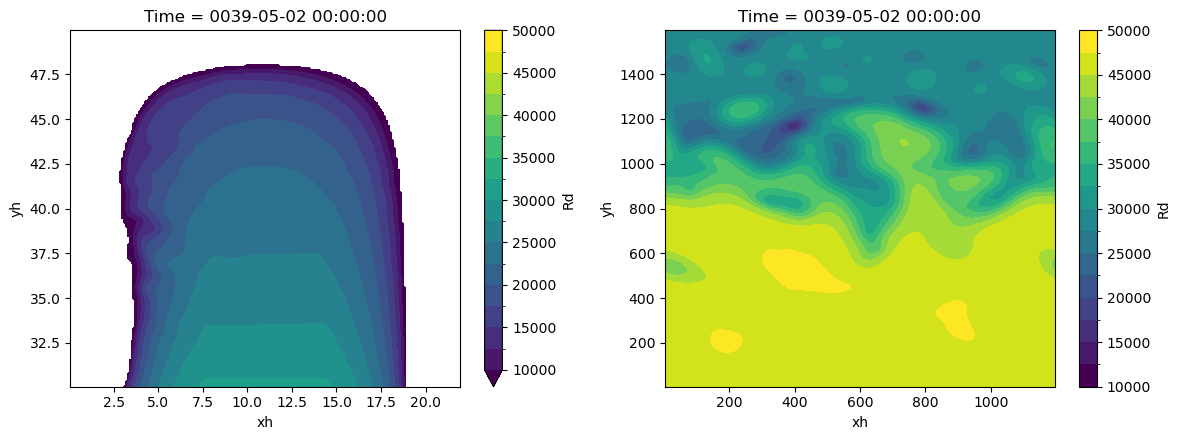

In [75]:
plt.figure(figsize= (12, 4.5))

lev = np.linspace(10, 50, 17)*1e3

plt.subplot(121)
ds_DG.Rd.isel(Time=-1).plot.contourf(levels=lev, vmin=10e3, vmax=50e3)

plt.subplot(122)
ds_P2L.Rd.isel(Time=-1).plot.contourf(levels=lev, vmin=10e3, vmax=50e3)

plt.tight_layout()

In [76]:
ds_DG.xh.diff('xh')[0].values
ds_DG.yh.diff('yh')[0].values

array(0.09090909)

In [77]:
dx = 110e3* ds_DG.xh.diff('xh')[0].values * np.cos(ds_DG.yh*np.pi/180)
dy = 110e3* ds_DG.yh.diff('yh')[0].values 

area = dx*dy

L = np.sqrt(area)

L_map = (0.*ds_DG.delta.isel(Time=0)+1.)*L

ds_DG['filter_scale'] = L_map*5

In [80]:
dx = 1e3* ds_P2L.xh.diff('xh')[0].values 
dy = 1e3* ds_P2L.yh.diff('yh')[0].values

area = dx*dy

L = np.sqrt(area)

L_map = (0.*ds_P2L.delta.isel(Time=0)+1.)*L

ds_P2L['filter_scale'] = L_map*5

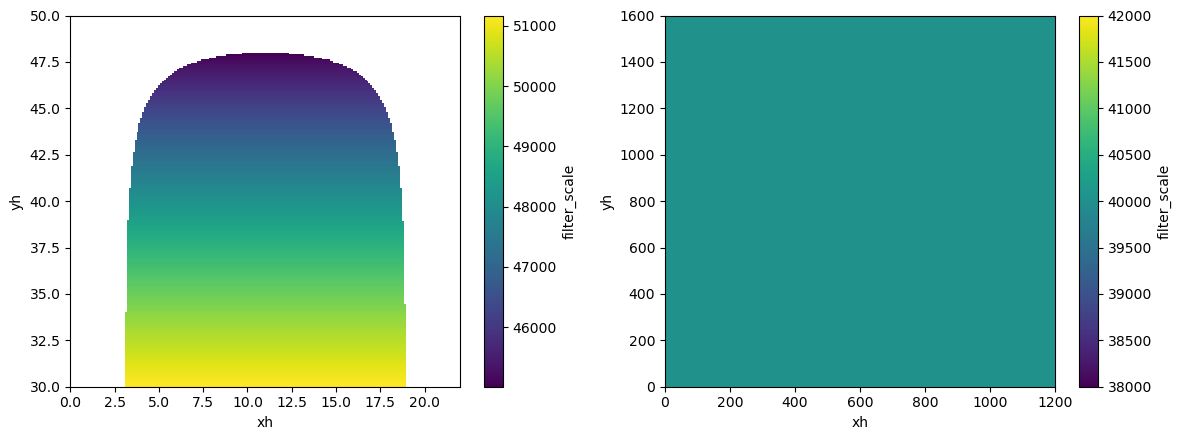

In [81]:
plt.figure(figsize= (12, 4.5))


plt.subplot(121)
ds_DG.filter_scale.plot()

plt.subplot(122)
ds_P2L.filter_scale.plot()

plt.tight_layout()

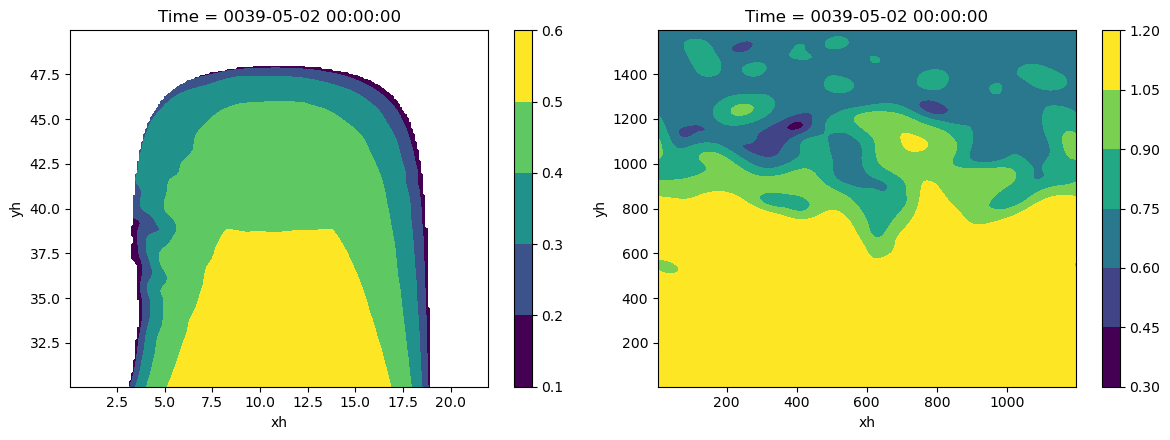

In [82]:
plt.figure(figsize= (12, 4.5))


plt.subplot(121)
(ds_DG.Rd/ds_DG.filter_scale).isel(Time=-1).plot.contourf()

plt.subplot(122)
(ds_P2L.Rd/ds_P2L.filter_scale).isel(Time=-1).plot.contourf()

plt.tight_layout()